# Normalizing Flows

In [122]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt #plotting package 
import scipy.stats as stats #statistical distributions
#plt.style.use('/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/LV/paper2.mplstyle') #formatting for plotsv

In [19]:
import torch
import torch.nn as nn 
from math import pi 

from torch.utils.data import DataLoader
from functools import partial
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

import tensorflow as tf

## Overview

A normalizing flow is a tranformation of a simple probablity distribution (typically chosen to be the normal distribution) into a more complex probability distribution through a sequence of invertible and differentiable maps. The result is a way to construct families of distributions by chaining together some number of parameterized transformations. 

Let $Z \in \mathbb{R}^d$ be a random variable with a known probability density function $p_Z: \mathbb{R}^D\rightarrow \mathbb{R}$ and let $g$ be an invertible function $Y = g(Z)$ Then the change of variables formula gives us the probability density function of the the random variable $Y$:

$$ p_{Y}(y) = p_{Z}(f(y))|{\rm det}(\partial f/\partial y)|$$
$$ \quad \quad \quad \quad  = p_{Z}(f(y))|{\rm det}(\partial g(f(y))/\partial z)|^{-1}$$

where $f$ is the inverse of $g$. The new density function $p_{Y}$ is called the $\it{pushforward}$ of the density $p_{Z}$. The generator $g$ pushes forward the base density $p_{Z}$ (the noise) to a more complex density. This defines the $\it{generative \; direction}$. 

The inverse function $f$ moves in the $\it{normalizing \; direction}$: from a complicated distribution to a more simple "normal" base measure $p_{Z}$.

We can compose any number of invertible, differentiable maps together to construct more complicated fucntions. Let $g_1,...,g_N$ be a set of $N$ bijective functions whose composition is $g = g_N\circ g_{N-1}\cdots \circ g_1$. Then $g$ is also bijective and its inverse is 

$$ f = f_1\circ \cdots \circ f_N$$

The determinant of the Jacobian is 

$$ {\rm det}(\partial f/\partial y) = \prod_{i = 1}^N {\rm det} (\partial f_i/\partial x).$$

## Distributions

For this example, we work in two-dimensions and use a latent distrubution with a normal probablity density function.

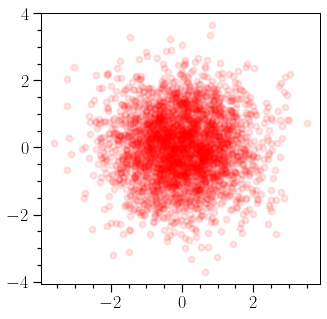

In [121]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(3000,))
plt.scatter(np.array(Z[:, 0]),np.array(Z[:, 1]),alpha = 0.1,color = "red")
plt.show()

## Real NVP Model

The Real Non-Volume Preserving Model is a map that consists of an additive coupling layer and a scaling layer. The corresponding determinant of the Jacobian of this map is not eqaul to one, and hence this map does not preserve volumes. This model falls under the category of Coupling Flows in which the observed input is divided into two disjoint subspaces 

$$ (x^A,x^B) \in \mathbb{R}^d \times \mathbb{R}^{D-d}$$

and a bijection $h(\cdot,\theta):\mathbb{R}^d\rightarrow \mathbb{R}^d$ is applied to the second subspace. The Real NVP defines $h$ in terms of an additive coupling function and an affine coupling function in the following way: 

$$ z^A = x^A $$ 
$$ z^B = x^B\odot\exp(\sigma(x^A))+\mu(x^A) $$

where $\sigma,\mu: \mathbb{R}^k\rightarrow \mathbb{R}^{d-k}$

In [30]:
class NormalizingFlow(nn.Module):
    
    def __init__(self,latent,flows):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = flows
        
    def latent_log_prob(self,z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)
    
    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))
    
    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from 
        the latent distribution and passing through g'''
        return self.g(self.latent_sample(num_samples,))
    
    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant 
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            a, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det
        
        return z, sum_log_abs_det
    
    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)
                
        return x 
    
    def g_steps(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        
        return xs 
    
    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        ''' Computes log p(x) using the change of variables formula'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z)+log_abs_det
    
    def __len__(self) -> int:
        return len(self.flows)

In [40]:
class AffineCouplingLayer(nn.Module):
    
    def __init__(
    self,
    theta: nn.Module,
    split
    ):
        super(AffineCouplingLayer,self).__init__()
        self.theta = theta
        self.split = split 
        
    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x) 
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1)
        return torch.cat((z1, z2), dim = -1), log_det
    
    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z) 
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim = -1)

In [43]:
class Conditioner(nn.Module):
    
    def __init__(
    self, in_dim: int, out_dim: int,
    num_hidden: int, hidden_dim: int,
    num_params: int
    ):
        super(Conditioner, self).__init__()
        self.input = nn.Linear(in_dim,hidden_dim)
        self.hidden = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_hidden)
        ])
        
        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim*num_params)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))
            
        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        params = batch_params.chunk(self.num_params, dim = -1) 
        return [p.squeeze(-1) for p in params]

In [44]:
def affine_coupling_flows(

    data_dim: int,
    hidden_dim: int,
    num_hidden: int,
    num_params: int,
    num_flows: int,
    device: str
) -> nn.Module:
    
    def flow():
        split = partial(torch.chunk, chunks = 2, dim = -1)
        theta = Conditioner( 
            in_dim = data_dim // 2,
            out_dim = data_dim // 2,
            num_params = num_params,
            hidden_dim = hidden_dim,
            num_hidden = num_hidden,
        )
        
        return AffineCouplingLayer(theta, split)
    
    latent = MultivariateNormal( 
        torch.zeros(data_dim).to(device),
        torch.eye(data_dim).to(device)
    )
    flows = nn.ModuleList([flow() for _ in range(num_flows)])
    return NormalizingFlow(latent, flows)

### Target Data 

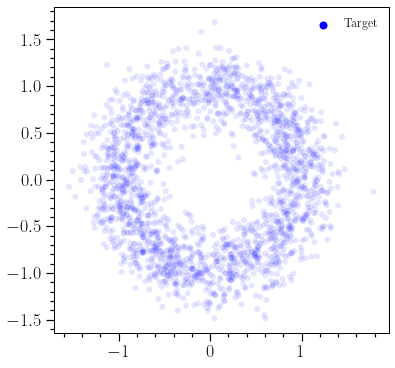

In [129]:
n_samples = 2000
r_array = np.random.normal(size = 2*n_samples, scale = 0.2, loc = 1)
phi_array = np.random.rand(n_samples)*2*np.pi

arr = np.zeros((2,n_samples),dtype = 'float')
for i, (r,phi) in enumerate(zip(r_array,phi_array)):
    arr[:,i] = [r_array[i]*np.cos(phi_array[i]),r_array[i]*np.sin(phi_array[i])]
    
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(arr[0],arr[1],alpha = 0.1, edgecolor = 'none',color = 'blue')
plt.scatter([],[],label = 'Target', color = 'blue')
plt.legend()

plt.show()

### Base Distribution

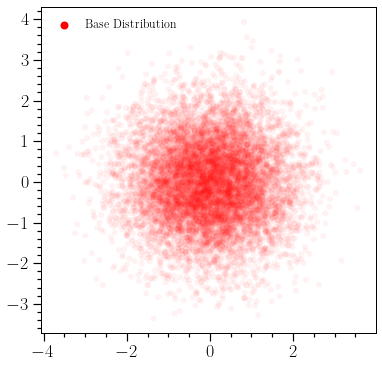

In [130]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
base_dist = base_dist.sample(sample_shape = torch.Size([5*n_samples]))

fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(np.array(base_dist[:, 0]),np.array(base_dist[:, 1]),alpha = 0.05,color = 'red',edgecolor = 'none')
plt.scatter([],[],color = 'red',label = 'Base Distribution')
plt.legend()

plt.show()

### Setting the Hyperparameters

In [131]:
target_data = torch.from_numpy(arr.T).float()

def simple_model(device = 'cpu'):
    return affine_coupling_flows(
        data_dim = target_data.size()[1],
        hidden_dim = 100,
        num_hidden = 2,
        num_flows = 5,
        num_params = 2,
        device = device
    ).to(device)

### Training Logic

In [132]:
def train(
    model: nn.Module,
    train_loader:DataLoader,
    num_epochs: int,
    args
) -> torch.Tensor:
    
    def _train(epoch, log_interval = 50):
        model.train()
        losses = torch.zeros(len(train_loader))
        for i,x in enumerate(train_loader):
            optimizer.zero_grad()
            loss = -model.log_prob(x.to(device)).mean()
            loss.backward()
            losses[i] = loss.item()
            optimizer.step()
            
        return losses.mean().item()
    
    def log_training_results(loss,epoch,log_interval):
        if epoch % log_interval == 0:
            print("Training Results - Epoch: {} Avg train loss: {:.2f}".format(epoch, loss))
            
    optimizer = torch.optim.AdamW(model.parameters(),lr = args['lr'])
    num_steps = len(train_loader)*num_epochs
    scheduler = StepLR(
        optimizer,
        step_size = args['lr_decay_interval'],
        gamma = args['lr_decay_rate']
    ) 
    
    train_losses = []
    for epoch in range(num_epochs+1):
        loss = _train(epoch)
        log_training_results(loss, epoch, log_interval = 100)
        train_losses.append(loss)
        scheduler.step()
        
    return train_losses

def train_new_model(data, num_epochs, args):
    np.random.seed(1)
    model = simple_model()
    loader = partial(DataLoader, batch_size = 32, shuffle = True)
    loss = train(
        model = model,
        train_loader = loader(data),
        num_epochs = num_epochs,
        args = args
    )
    
    return model, loss

In [133]:
args = {'lr_decay_interval': 20,
        'lr_decay_rate': .01,
        'lr': 1e-6}

device = 'cpu'
train_with_args = partial(train_new_model, num_epochs = 100, args = args)
model, loss = train_with_args(target_data)

Training Results - Epoch: 0 Avg train loss: 1.28
Training Results - Epoch: 100 Avg train loss: 0.88


### Plotting the final result 

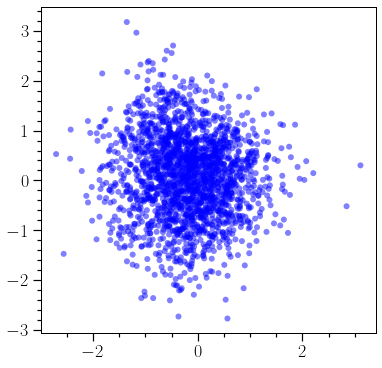

In [134]:
fig, ax = plt.subplots(figsize = (6,6))
prediction = model.sample(num_samples = 2000)
plt.scatter(prediction[:,0],prediction[:,1],color = 'blue',edgecolor = 'none', label = 'Prediction',alpha = 0.5)

### Plotting steps at each flow

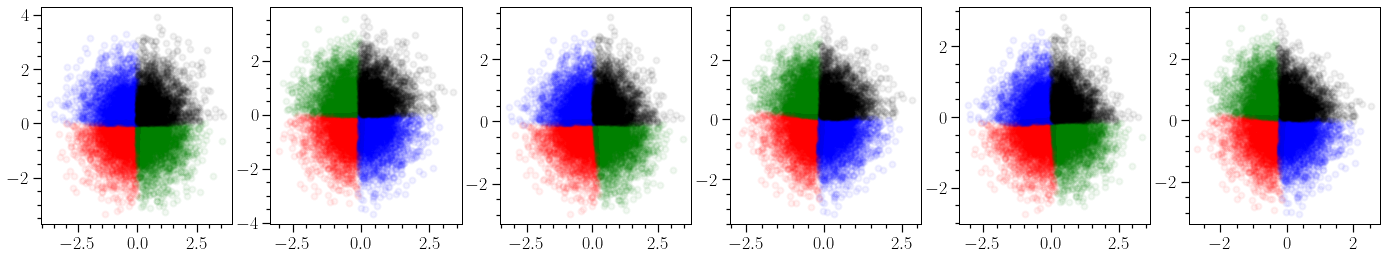

In [135]:
steps = model.g_steps(base_dist)
X0 = steps[0].detach().numpy()
f, arr = plt.subplots(1, len(steps), figsize=(4 * (len(steps)), 4))
for i in range(len(steps)): 
    X1 = steps[i].detach().numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='red',alpha = 0.05)
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='green',alpha = 0.05)
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='blue',alpha = 0.05)
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='black',alpha = 0.05)
    #arr[i].set_title("{}".format(model.flows[i]))


## Exercise 1

Follow the same steps to generate events corresponding to the following distribution: 

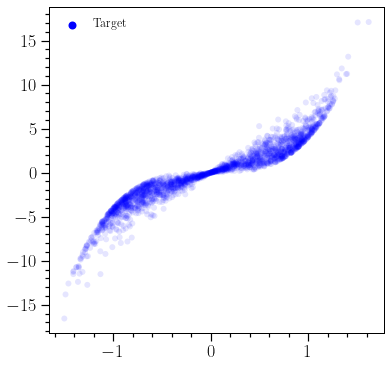

In [117]:
n_samples = 2000
r_array = np.random.normal(size = 2*n_samples, scale = 0.2, loc = 1)
phi_array = np.random.rand(n_samples)*2*np.pi

arr = np.zeros((2,n_samples),dtype = 'float')
for i, (r,phi) in enumerate(zip(r_array,phi_array)):
    arr[:,i] = [r_array[i]*np.sin(phi_array[i]),4*r_array[i]**3*np.sin(phi_array[i])]
    
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(arr[0],arr[1],alpha = 0.1, edgecolor = 'none',color = 'blue')
plt.scatter([],[],label = 'Target', color = 'blue')
plt.legend()
plt.show()

How does this change if you vary the hyperparameters? Verify that the inverse takes you back to the base distribution.

## Exercise 2

Now try the same with a three-dimensional target distribution (you'll need to modify the base distribution so that it's defined in three dimensions as well). 

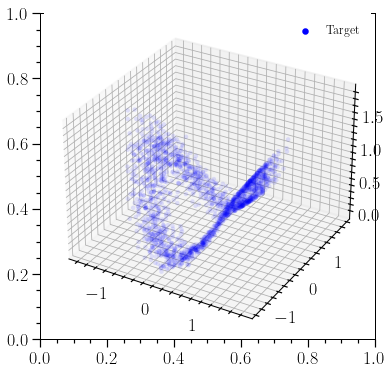

In [116]:
n_samples = 2000
r_array = np.random.normal(size = 2*n_samples, scale = 0.2, loc = 1)
phi_array = np.random.rand(n_samples)*2*np.pi

arr = np.zeros((3,n_samples),dtype = 'float')
for i, (r,phi) in enumerate(zip(r_array,phi_array)): 
    #arr[:,i] = [r,phi,phi**3-r**3]
    arr[:,i] = [r*np.cos(phi),r*np.sin(phi),r*np.cos(phi)**2]
    
fig, ax = plt.subplots(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(arr[0],arr[1],arr[2],alpha = 0.1, edgecolor = 'none',color = 'blue')
ax.scatter([],[],[],label = 'Target', color = 'blue')
plt.legend()
plt.show()